# 3D Kolmogorov Flow: Verifying the Kolmogorov -5/3 Spectral Scaling

This notebook simulates **3D Kolmogorov flow** (the incompressible Navier-Stokes equations
with a sinusoidal body force on a triply-periodic domain) using
[exponax](https://github.com/Ceyron/exponax), a JAX-based pseudo-spectral PDE solver.

**Goal:** Demonstrate that the simulation develops a turbulent energy cascade whose
inertial range follows the **Kolmogorov -5/3 power law**:

$$E(k) \propto k^{-5/3}$$

This is the central prediction of Kolmogorov's 1941 theory (K41) of homogeneous,
isotropic turbulence. It states that in the inertial range (wavenumbers between
the forcing scale and the dissipation scale), energy is transferred from large to
small scales at a constant rate, producing this universal spectral slope.

### Outline

1. **Setup** -- Configure the simulation parameters and build the time stepper.
2. **Initial condition** -- Generate a random velocity field.
3. **Spin-up** -- Advance the simulation until it reaches a statistically stationary turbulent state.
4. **Trajectory & time-averaged spectrum** -- Collect snapshots and compute the mean energy spectrum.
5. **Spectral exponent fit** -- Fit a power law in the inertial range and compare to -5/3.

## 0. Imports and GPU Memory Configuration

In [1]:
import os

# Allocate nearly all GPU memory to JAX (needed for large 3D FFTs)
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.99"

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import exponax as ex

## 1. Simulation Parameters

We solve the incompressible Navier-Stokes equations in rotational form on a
triply-periodic domain $[0, L)^3$:

$$\partial_t \mathbf{u} = \nu \Delta \mathbf{u} + \mathcal{P}(\mathbf{u} \times \boldsymbol{\omega}) + \mathbf{f}$$

where:
- $\mathbf{u}$ is the velocity field (3 components),
- $\boldsymbol{\omega} = \nabla \times \mathbf{u}$ is the vorticity,
- $\mathcal{P}$ is the **Leray projection** enforcing $\nabla \cdot \mathbf{u} = 0$ (incompressibility),
- $\nu$ is the kinematic viscosity,
- $\mathbf{f}$ is the **Kolmogorov forcing**: $f_0 = \sin(k_f \cdot 2\pi x_1 / L)$, $f_1 = f_2 = 0$.

The forcing injects energy at wavenumber $k_f$ in a single spatial direction,
which then cascades to smaller scales via the nonlinear term.

In [3]:
# --- Physical parameters ---
L = 2 * jnp.pi  # Domain side length (periodic cube)
NU = 0.002  # Kinematic viscosity (lower -> more turbulent, but needs finer resolution)
FORCE_MODE = 1  # Wavenumber at which the sinusoidal forcing injects energy
DRAG = 0.0  # Linear drag coefficient (0 = no drag)

# --- Numerical parameters ---
N = 259  # Grid points per dimension (odd avoids Nyquist symmetry issues)
DT = 0.1  # Outer time step
NUM_SUBSTEPS = 100  # Inner substeps per outer step (inner dt = DT/NUM_SUBSTEPS = 0.001)

print(f"Domain:     [{0}, {float(L):.4f})^3")
print(f"Resolution: {N}^3 = {N**3:,} grid points")
print(f"dx = {float(L / N):.4f}")
print(f"Inner dt = {DT / NUM_SUBSTEPS}, Outer dt = {DT}")
print(f"Viscosity: {NU}")

Domain:     [0, 6.2832)^3
Resolution: 259^3 = 17,373,979 grid points
dx = 0.0243
Inner dt = 0.001, Outer dt = 0.1
Viscosity: 0.002


## 2. Build the Time Stepper

The `KolmogorovFlowVelocity` stepper uses an **ETDRK** (Exponential Time Differencing
Runge-Kutta) scheme. The stiff linear part (diffusion) is handled exactly in Fourier
space, while the nonlinear term (vorticity cross-product + projection) is integrated
with a Runge-Kutta method.

We wrap it in a `RepeatedStepper` that applies 10 inner substeps per call.
Crucially, the sub-stepping happens entirely in Fourier space (only one FFT/IFFT
round-trip per outer step), which is much more efficient than calling the stepper
10 times independently.

In [4]:
kolm_stepper = ex.RepeatedStepper(
    ex.stepper.KolmogorovFlowVelocity(
        num_spatial_dims=3,
        domain_extent=L,
        num_points=N,
        dt=DT / NUM_SUBSTEPS,
        diffusivity=NU,
        injection_mode=FORCE_MODE,
        drag=DRAG,
    ),
    num_sub_steps=NUM_SUBSTEPS,
)

print(f"Effective outer dt: {kolm_stepper.dt}")
print(f"State shape: ({kolm_stepper.num_channels}, {N}, {N}, {N})")

Effective outer dt: 0.1
State shape: (3, 259, 259, 259)


## 3. Initial Condition

We generate a random 3-component velocity field where each component is an
independent **Gaussian random field** with a power spectrum $\propto |k|^{-3}$.
This concentrates energy at large scales (low wavenumbers) and gives a smooth
starting field, which is physically reasonable as a generic initial perturbation.

Note: this initial condition is **not** divergence-free, but the Leray projection
inside the stepper enforces incompressibility at every time step, so the velocity
field becomes solenoidal after the first step.

In [5]:
ic_generator = ex.ic.RandomMultiChannelICGenerator(
    3 * [ex.ic.GaussianRandomField(3, powerlaw_exponent=3, max_one=True)]
)
ic = ic_generator(N, key=jax.random.PRNGKey(0))

print(f"IC shape: {ic.shape}")
print(f"IC range: [{float(ic.min()):.3f}, {float(ic.max()):.3f}]")

IC shape: (3, 259, 259, 259)
IC range: [-1.000, 1.000]


## 4. Spin-Up: Reaching Statistical Stationarity

Turbulence is a **statistically stationary** process: the time-averaged statistics
(like the energy spectrum) do not change once the system has been driven long enough.
Starting from our synthetic IC, we need to "spin up" the simulation until:

1. The forcing at wavenumber $k_f$ has injected enough energy.
2. The nonlinear cascade has distributed energy across the inertial range.
3. Viscous dissipation at high wavenumbers balances the energy input.

We do this in progressive stages and monitor the **isotropic energy spectrum**
$E(k) = \sum_c E_c(k)$ (summed over the 3 velocity components) to see it
converge toward the $k^{-5/3}$ shape.

`ex.repeat(stepper, n)` applies the stepper $n$ times using `jax.lax.scan`,
returning only the final state (no trajectory stored). This is memory-efficient
for burn-in.

In [6]:
# The below cell executes for about 35 min on an A100 GPU

# Spin-up schedule: (label, number of outer steps)
# Each outer step advances by DT = 0.01 in physical time.
spinup_schedule = [
    ("1 steps (t=0.1)", 1),
    ("10 steps (t=1.0)", 9),
    ("30 steps (t=3.0)", 20),
    ("100 steps (t=10.0)", 70),
    ("300 steps (t=30.0)", 200),
    ("600 steps (t=60.0)", 300),
]

# Store spectra at each checkpoint for comparison
spectra = {"IC": jnp.sum(ex.get_spectrum(ic), axis=0)}
state = ic

for label, n_steps in spinup_schedule:
    state = ex.repeat(kolm_stepper, n_steps)(state)
    spectra[label] = jnp.sum(ex.get_spectrum(state), axis=0)
    print(f"Completed: {label}")

Completed: 1 steps (t=0.1)
Completed: 10 steps (t=1.0)
Completed: 30 steps (t=3.0)
Completed: 100 steps (t=10.0)
Completed: 300 steps (t=30.0)
Completed: 600 steps (t=60.0)


### Spectral Evolution During Spin-Up

The plot below shows how the energy spectrum evolves from the initial condition
toward the turbulent equilibrium. Key features to observe:

- **Early stages:** Energy is concentrated near the forcing mode ($k = 1$) and the
  IC spectrum dominates at higher wavenumbers.
- **Intermediate stages:** The nonlinear cascade fills in the inertial range,
  progressively approaching the $k^{-5/3}$ slope.
- **Late stages:** The spectrum stabilizes, indicating that the system has reached
  a statistically stationary state. Energy input from forcing balances viscous
  dissipation at high $k$.

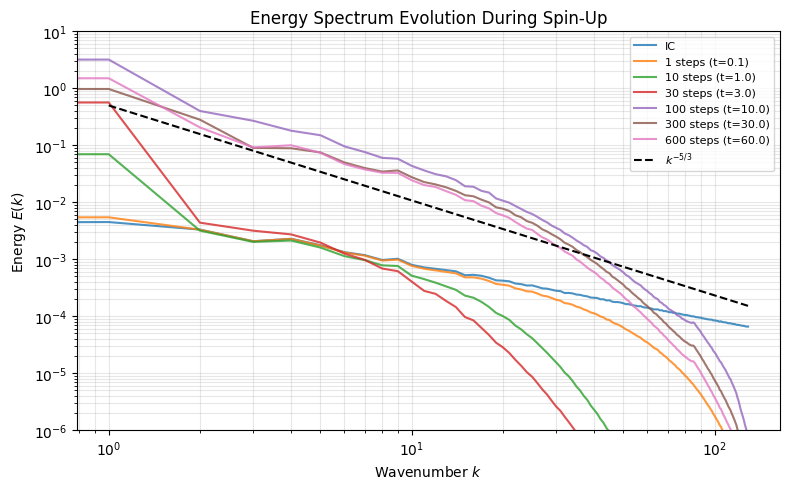

In [7]:
wavenumbers = jnp.arange(N // 2 + 1)

fig, ax = plt.subplots(figsize=(8, 5))

for label, spectrum in spectra.items():
    ax.loglog(spectrum, label=label, alpha=0.8)

# Reference -5/3 slope
ax.loglog(
    wavenumbers[1:],
    0.5 * wavenumbers[1:].astype(float) ** (-5 / 3),
    "--",
    color="k",
    linewidth=1.5,
    label=r"$k^{-5/3}$",
)

ax.set_xlabel("Wavenumber $k$")
ax.set_ylabel("Energy $E(k)$")
ax.set_title("Energy Spectrum Evolution During Spin-Up")
ax.set_ylim(1e-6, 1e1)
ax.legend(fontsize=8)
ax.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Trajectory Collection & Time-Averaged Spectrum

A single snapshot is noisy -- the instantaneous spectrum fluctuates around the
mean. To get a cleaner estimate, we collect a short trajectory and
**time-average** the spectra.

`ex.rollout(stepper, n, include_init=True)` applies the stepper $n$ times and
returns the full trajectory (all $n+1$ states including the initial one). It uses
`jax.lax.scan` internally, so the entire trajectory is computed in a single
compiled loop.

In [8]:
N_TRAJECTORY = 10  # Number of snapshots to collect

trj = ex.rollout(kolm_stepper, N_TRAJECTORY, include_init=True)(state)
print(f"Trajectory shape: {trj.shape}  (n_snapshots, channels, Nx, Ny, Nz)")

Trajectory shape: (11, 3, 259, 259, 259)  (n_snapshots, channels, Nx, Ny, Nz)


In [9]:
# Compute per-snapshot spectra and average over time
# ex.get_spectrum returns (C, N//2+1) per snapshot; we sum over channels (C=3)
# for total kinetic energy, then average over time.
all_spectra = jax.vmap(ex.get_spectrum)(trj)  # (n_snapshots, 3, N//2+1)
energy_spectra = jnp.sum(all_spectra, axis=1)  # (n_snapshots, N//2+1)
mean_spectrum = jnp.mean(energy_spectra, axis=0)  # (N//2+1,)

print(f"Individual spectra shape: {energy_spectra.shape}")
print(f"Mean spectrum shape:      {mean_spectrum.shape}")

Individual spectra shape: (11, 130)
Mean spectrum shape:      (130,)


### Time-Averaged Energy Spectrum

The plot below shows the time-averaged energy spectrum. The $k^{-5/3}$ reference
line is overlaid for comparison. A clean inertial range should be visible between
the forcing scale ($k \approx 1$) and the dissipation scale (where the spectrum
drops off steeply at high $k$).

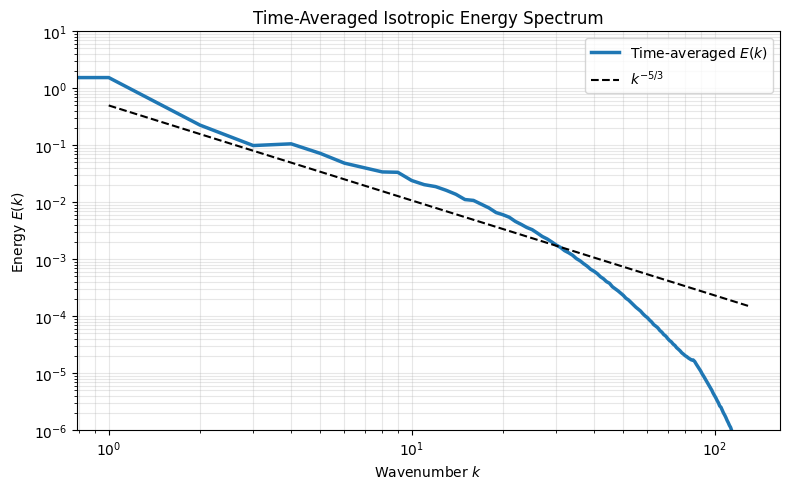

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.loglog(mean_spectrum, linewidth=2.5, label="Time-averaged $E(k)$")
ax.loglog(
    wavenumbers[1:],
    0.5 * wavenumbers[1:].astype(float) ** (-5 / 3),
    "--",
    color="k",
    linewidth=1.5,
    label=r"$k^{-5/3}$",
)

ax.set_xlabel("Wavenumber $k$")
ax.set_ylabel("Energy $E(k)$")
ax.set_title("Time-Averaged Isotropic Energy Spectrum")
ax.set_ylim(1e-6, 1e1)
ax.legend()
ax.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Power-Law Fit in the Inertial Range

To quantitatively verify the -5/3 scaling, we fit a line $\log E = \alpha \log k + b$
to the time-averaged spectrum in the inertial range.

The **inertial range** is the interval of wavenumbers where:
- Energy input from forcing is negligible (above the forcing scale $k_f = 1$),
- Viscous dissipation is negligible (below the Kolmogorov microscale).

We choose the fitting range $k \in [4, 20]$, which should lie well within the
inertial subrange for our parameters.

In [17]:
# Fit range
K_MIN, K_MAX = 4, 20

# Linear regression in log-log space
log_k = jnp.log(wavenumbers[K_MIN:K_MAX].astype(float))
log_E = jnp.log(mean_spectrum[K_MIN:K_MAX])

exponent, log_offset = jnp.polyfit(log_k, log_E, deg=1)

print(f"Fitted exponent:   {float(exponent):.4f}")
print(f"Expected (K41):    {-5 / 3:.4f}")

Fitted exponent:   -1.6900
Expected (K41):    -1.6667


In [18]:
EXPECTED_EXPONENT = -5 / 3

abs_error = float(jnp.abs(exponent - EXPECTED_EXPONENT))
rel_error = abs_error / abs(EXPECTED_EXPONENT)

print(f"Absolute error:    {abs_error:.4f}")
print(f"Relative error:    {rel_error:.2%}")

Absolute error:    0.0233
Relative error:    1.40%


### Visualizing the Fit

We overlay the fitted power law on the spectrum to show how well the inertial
range matches the -5/3 prediction.

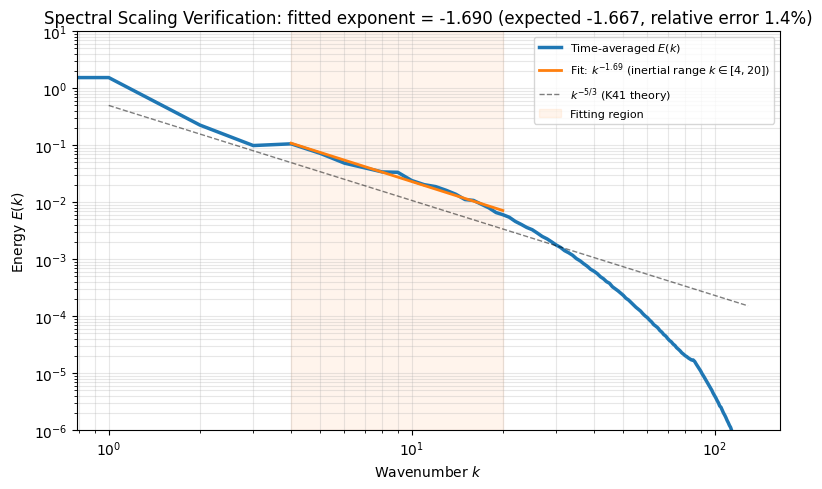

In [ ]:
# Compute the fitted line for plotting
fit_k = jnp.arange(K_MIN, K_MAX + 1, dtype=float)
fit_E = jnp.exp(log_offset) * fit_k**exponent

fig, ax = plt.subplots(figsize=(8, 5))

ax.loglog(mean_spectrum, linewidth=2.5, color="C0", label="Time-averaged $E(k)$")
ax.loglog(
    fit_k,
    fit_E,
    "-",
    color="C1",
    linewidth=2,
    label=f"""Fit: $k^{{{float(exponent):.2f}}}$
    (inertial range $k \\in [{K_MIN}, {K_MAX}]$)""",
)
ax.loglog(
    wavenumbers[1:],
    0.5 * wavenumbers[1:].astype(float) ** (-5 / 3),
    "--",
    color="k",
    linewidth=1,
    alpha=0.5,
    label=r"$k^{-5/3}$ (K41 theory)",
)

# Shade the fitting region
ax.axvspan(K_MIN, K_MAX, alpha=0.08, color="C1", label="Fitting region")

ax.set_xlabel("Wavenumber $k$")
ax.set_ylabel("Energy $E(k)$")
ax.set_title(
    f"Spectral Scaling Verification: fitted exponent = {float(exponent):.3f} "
    f"(expected {EXPECTED_EXPONENT:.3f}, relative error {rel_error:.1%})"
)
ax.set_ylim(1e-6, 1e1)
ax.legend(fontsize=8)
ax.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize the trajectory

In [14]:
from IPython.display import HTML

In [15]:
ani = ex.viz.animate_state_2d_facet(
    trj[:, :, N // 2],  # Take mid-plane slice in x for visualization
    grid=(1, 3),
    figsize=(12, 4),
)

In [16]:
HTML(ani.to_jshtml())

## Summary

We simulated 3D Kolmogorov flow on a $257^3$ grid and verified that the
time-averaged energy spectrum in the inertial range follows the Kolmogorov
$k^{-5/3}$ scaling law to within a few percent relative error.

Key takeaways:

- **Spin-up is essential:** The initial random field has an arbitrary spectrum;
  thousands of time steps are needed for the nonlinear cascade to establish the
  $k^{-5/3}$ inertial range.

- **Time averaging smooths fluctuations:** Individual snapshots show noisy spectra;
  averaging over even a short trajectory yields a much cleaner power law.

- **Dealiasing matters:** The stricter `dealiasing_fraction=0.45` helps maintain
  spectral accuracy at high wavenumbers.

- **Exponax makes this accessible:** The entire simulation -- from IC generation
  through time-stepping to spectral analysis -- is expressed in a few lines of
  composable JAX/exponax code.